In [14]:
# %%  ———————  EVALUATE MODEL ———————
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from model.cnn import miniVGG   # hoặc simpleCNN
# ====== THÔNG SỐ ======
device = 'cuda' if torch.cuda.is_available() else 'cpu'
CKPT_PATH = "Models/classification_best.pt"   # file lưu tốt nhất
IMG_SIZE = 224
BATCH_SIZE = 32
ROOT = "C:/TRAIN/Deep Learning/vietnamese-foods/Images"   # <== đổi nếu cần
root_train = f"{ROOT}/Train"
root_val   = f"{ROOT}/Validate"
root_test  = f"{ROOT}/Test"
# ====== TRANSFORM GIỐNG LÚC TRAIN ======
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
# ====== DATASET / DATALOADER ======
test_set = ImageFolder(root_test, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
CLASS_NAMES = test_set.classes
print("Số lớp:", len(CLASS_NAMES))
print("Ví dụ lớp:", CLASS_NAMES[:33])

Số lớp: 33
Ví dụ lớp: ['Banh beo', 'Banh bot loc', 'Banh can', 'Banh canh', 'Banh chung', 'Banh cuon', 'Banh duc', 'Banh gio', 'Banh khot', 'Banh mi', 'Banh pia', 'Banh tet', 'Banh trang nuong', 'Banh xeo', 'Bun bo Hue', 'Bun dau mam tom', 'Bun mam', 'Bun rieu', 'Bun thit nuong', 'Ca kho to', 'Canh chua', 'Cao lau', 'Chao long', 'Com tam', 'Goi cuon', 'Hu tieu', 'Mi quang', 'Nem chua', 'Pho', 'Xoi xeo', 'banh_da_lon', 'banh_tieu', 'banh_trung_thu']


In [15]:
# ====== KHỞI TẠO MÔ HÌNH ======
ckpt = torch.load(CKPT_PATH, map_location=device)

# ✅ Lấy đúng nhánh chứa state_dict
if "net" in ckpt:
    state_dict = ckpt["net"]
elif "model_state_dict" in ckpt:
    state_dict = ckpt["model_state_dict"]
else:
    state_dict = ckpt  # fallback nếu file là state_dict thuần

# ✅ Bỏ tiền tố 'module.' nếu có (trường hợp bạn train bằng DataParallel)
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "")  # loại bỏ tiền tố module.
    new_state_dict[name] = v

# ✅ Load state_dict an toàn
missing, unexpected = model.load_state_dict(new_state_dict, strict=False)
if missing:
    print("⚠️ Missing keys:", missing)
if unexpected:
    print("⚠️ Unexpected keys:", unexpected)

model.eval()
print("✅ Đã load mô hình thành công:", CKPT_PATH)


✅ Đã load mô hình thành công: Models/classification_best.pt


C:\Users\Admin\AppData\Local\Temp\ipykernel_27988\3735505895.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location=device)


In [19]:
# %% 0. IMPORTS & DATA
import os, numpy as np, torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE   = 224
BATCH_SIZE = 32

# Đổi thư mục nếu bạn để nơi khác
TEST_DIR = r"C:/TRAIN/Deep Learning/vietnamese-foods/Images/Test"

# Transform giống lúc train/infer
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),                 # nếu lúc train có Normalize thì thêm Normalize vào đây
])

test_set   = ImageFolder(TEST_DIR, transform=test_transform)
test_loader= DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
CLASS_NAMES= test_set.classes
NUM_CLASSES= len(CLASS_NAMES)

print("Test samples:", len(test_set))
print("Số lớp:", NUM_CLASSES)
print("Ví dụ lớp:", CLASS_NAMES[:10])

Test samples: 5101
Số lớp: 33
Ví dụ lớp: ['Banh beo', 'Banh bot loc', 'Banh can', 'Banh canh', 'Banh chung', 'Banh cuon', 'Banh duc', 'Banh gio', 'Banh khot', 'Banh mi']


In [18]:
# %% 1. EVALUATE – y_true, y_pred, y_prob
@torch.no_grad()
def evaluate_collect(model, loader, device='cpu'):
    model.eval()
    y_true, y_pred = [], []
    y_prob_rows = []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        probs  = F.softmax(logits, dim=1)
        pred   = probs.argmax(dim=1)

        y_true.extend(y.cpu().tolist())
        y_pred.extend(pred.cpu().tolist())
        y_prob_rows.append(probs.cpu().numpy())

    y_prob = np.concatenate(y_prob_rows, axis=0)   # [N, C]
    acc = (np.array(y_true) == np.array(y_pred)).mean()
    print(f"✅ Test Accuracy: {acc*100:.2f}%")
    return y_true, y_pred, y_prob

y_true, y_pred, y_prob = evaluate_collect(model, test_loader, device)


✅ Test Accuracy: 67.69%


In [20]:
# %% 2. Classification Report
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=2))

                  precision    recall  f1-score   support

        Banh beo       0.76      0.70      0.73       129
    Banh bot loc       0.72      0.56      0.63       144
        Banh can       0.71      0.60      0.65       149
       Banh canh       0.46      0.33      0.38       193
      Banh chung       0.60      0.52      0.56       102
       Banh cuon       0.62      0.75      0.68       228
        Banh duc       0.49      0.24      0.32       133
        Banh gio       0.68      0.74      0.71       129
       Banh khot       0.76      0.66      0.71       167
         Banh mi       0.82      0.88      0.85       268
        Banh pia       0.73      0.81      0.77        89
        Banh tet       0.62      0.55      0.58       138
Banh trang nuong       0.82      0.72      0.77       159
        Banh xeo       0.71      0.72      0.71       235
      Bun bo Hue       0.68      0.74      0.71       306
 Bun dau mam tom       0.79      0.94      0.86       184
         Bun 

In [37]:
# %% CR → DataFrame
import pandas as pd
from sklearn.metrics import classification_report

report = classification_report(
    y_true, y_pred,
    target_names=CLASS_NAMES,
    output_dict=True,        # <— quan trọng để lấy dict
    zero_division=0
)

df_cr = pd.DataFrame(report).T
# chỉ giữ các lớp (bỏ 'accuracy', 'macro avg', 'weighted avg'…)
df_cls = df_cr.iloc[:len(CLASS_NAMES)][['precision', 'recall', 'f1-score', 'support']].copy()
df_cls.index.name = 'class'
df_cls.reset_index(inplace=True)

df_summary = df_cr.loc[['macro avg', 'weighted avg']][['precision','recall','f1-score']]
df_cls.head()


,class,precision,recall,f1-score,support
0,Banh beo,0.762712,0.697674,0.728745,129.0
1,Banh bot loc,0.720721,0.555556,0.627451,144.0
2,Banh can,0.714286,0.604027,0.654545,149.0
3,Banh canh,0.457143,0.331606,0.384384,193.0
4,Banh chung,0.602273,0.519608,0.557895,102.0


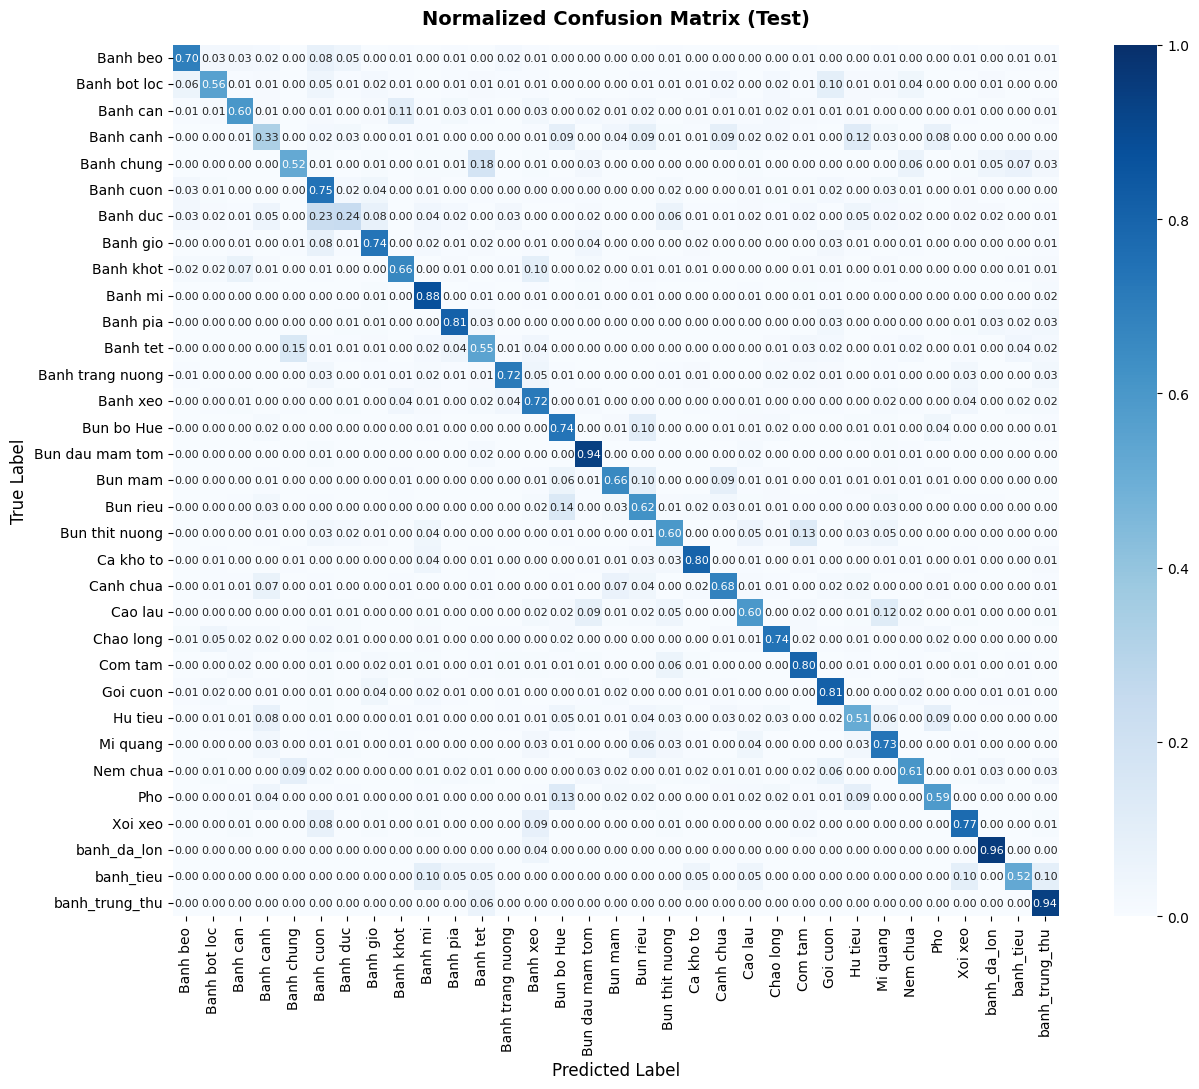

In [48]:
# %% 3. Confusion Matrix – seaborn (hiển thị số)
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(13, 11))
sns.heatmap(
    cm_norm,
    cmap="Blues",
    vmin=0, vmax=1,
    annot=True,        # 👈 Hiển thị số trên từng ô
    fmt=".2f",         # 👈 Làm tròn 2 chữ số thập phân
    annot_kws={"size": 8},  # 👈 Kích thước chữ nhỏ gọn
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.title("Normalized Confusion Matrix (Test)", fontsize=14, weight="bold", pad=15)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [53]:
# %% CR → DataFrame
import pandas as pd
from sklearn.metrics import classification_report

report = classification_report(
    y_true, y_pred,
    target_names=CLASS_NAMES,
    output_dict=True,        # <— quan trọng để lấy dict
    zero_division=0
)

df_cr = pd.DataFrame(report).T
# chỉ giữ các lớp (bỏ 'accuracy', 'macro avg', 'weighted avg'…)
df_cls = df_cr.iloc[:len(CLASS_NAMES)][['precision', 'recall', 'f1-score', 'support']].copy()
df_cls.index.name = 'class'
df_cls.reset_index(inplace=True)

df_summary = df_cr.loc[['macro avg', 'weighted avg']][['precision','recall','f1-score']]
df_cls.head()


,class,precision,recall,f1-score,support
0,Banh beo,0.762712,0.697674,0.728745,129.0
1,Banh bot loc,0.720721,0.555556,0.627451,144.0
2,Banh can,0.714286,0.604027,0.654545,149.0
3,Banh canh,0.457143,0.331606,0.384384,193.0
4,Banh chung,0.602273,0.519608,0.557895,102.0


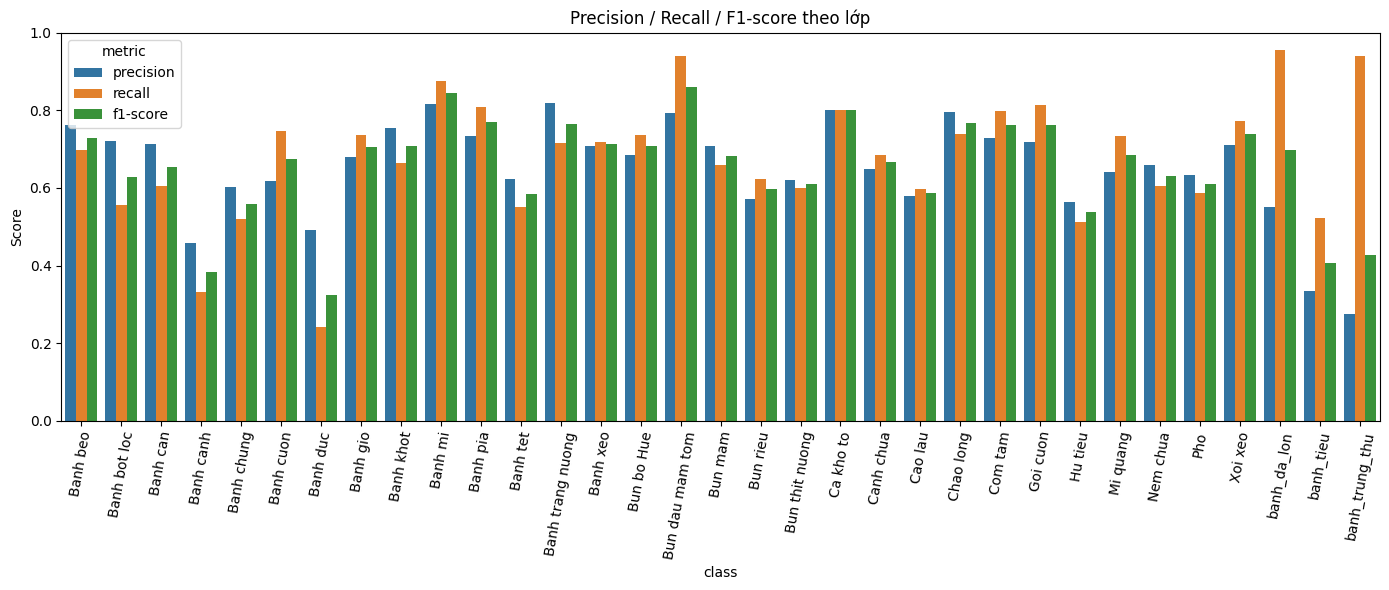

In [54]:
# %% Grouped barplot (per class)
import seaborn as sns
import matplotlib.pyplot as plt

long_df = df_cls.melt(
    id_vars=['class','support'],
    value_vars=['precision','recall','f1-score'],
    var_name='metric', value_name='score'
)

plt.figure(figsize=(14, 6))
sns.barplot(data=long_df, x='class', y='score', hue='metric')
plt.xticks(rotation=80)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Precision / Recall / F1-score theo lớp')
plt.tight_layout()
plt.show()


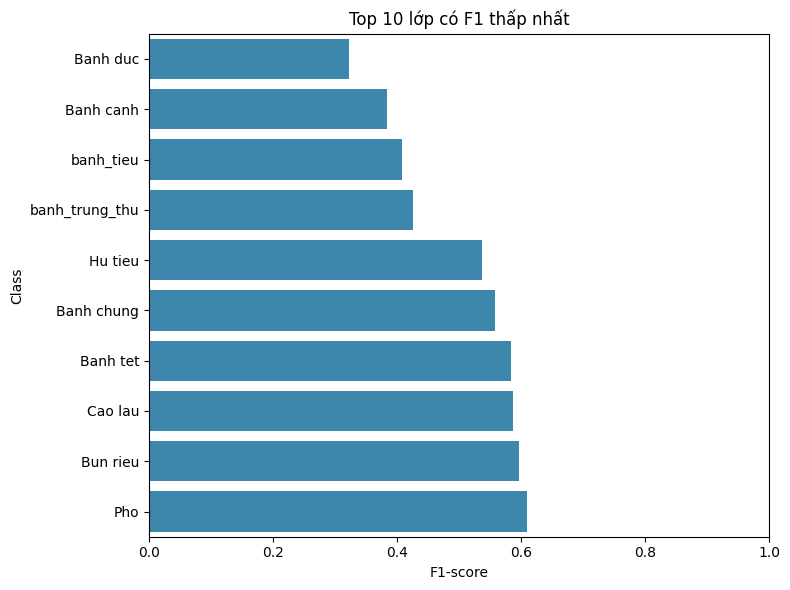

In [55]:
# %% Top-N lớp F1 thấp
TOP_N = 10
df_sorted = df_cls.sort_values('f1-score').head(TOP_N)

plt.figure(figsize=(8, 6))
sns.barplot(data=df_sorted, x='f1-score', y='class', color='#2b8cbe')
plt.xlim(0, 1)
plt.xlabel('F1-score')
plt.ylabel('Class')
plt.title(f'Top {TOP_N} lớp có F1 thấp nhất')
plt.tight_layout()
plt.show()


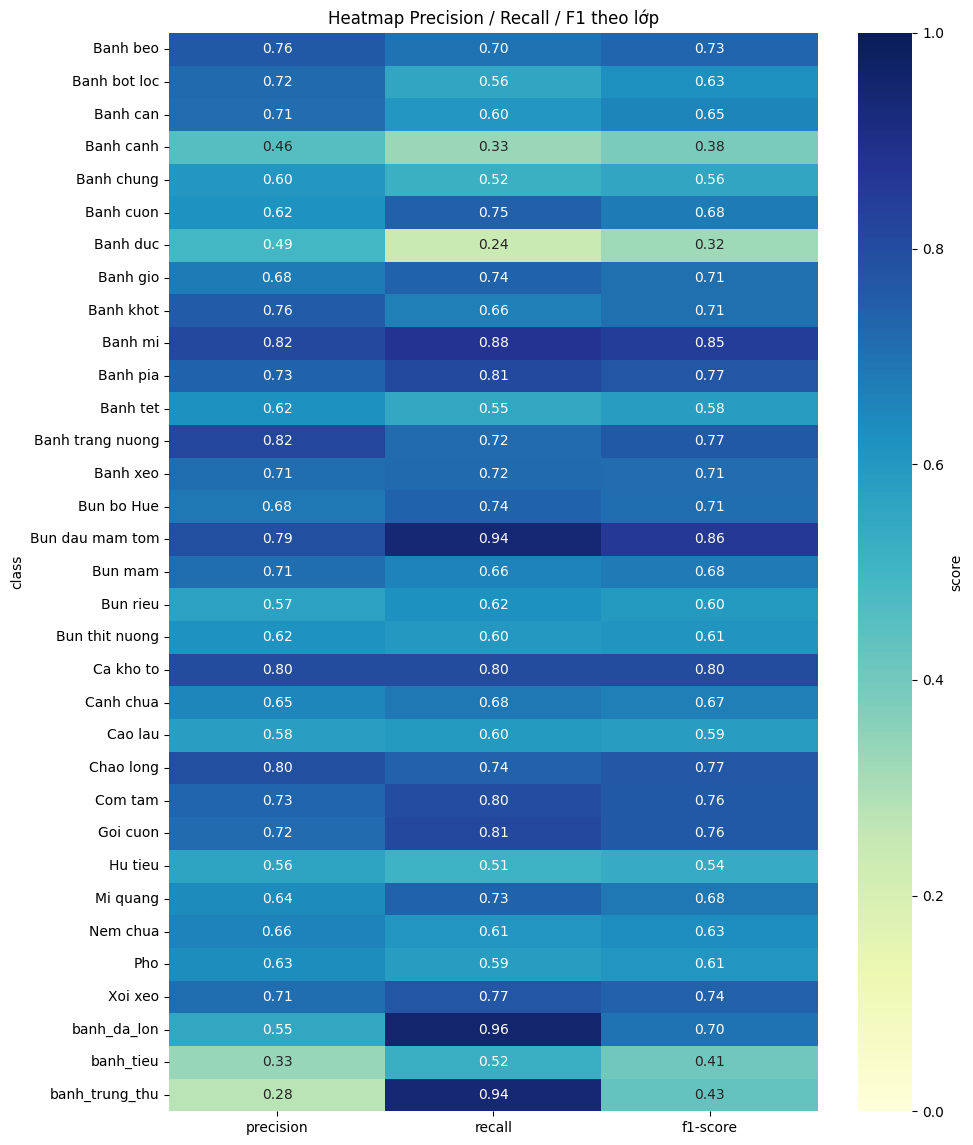

In [56]:
# %% Heatmap các metric
m = df_cls.set_index('class')[['precision','recall','f1-score']]
plt.figure(figsize=(10, max(6, len(CLASS_NAMES)*0.35)))
sns.heatmap(m, annot=True, fmt=".2f", cmap="YlGnBu", vmin=0, vmax=1,
            cbar_kws={'label': 'score'})
plt.title('Heatmap Precision / Recall / F1 theo lớp')
plt.tight_layout()
plt.show()


In [57]:
# %% Summary macro / weighted
display(df_summary.style.format("{:.3f}").set_caption("Tóm tắt macro & weighted"))


,precision,recall,f1-score
macro avg,0.652,0.679,0.654
weighted avg,0.677,0.677,0.672


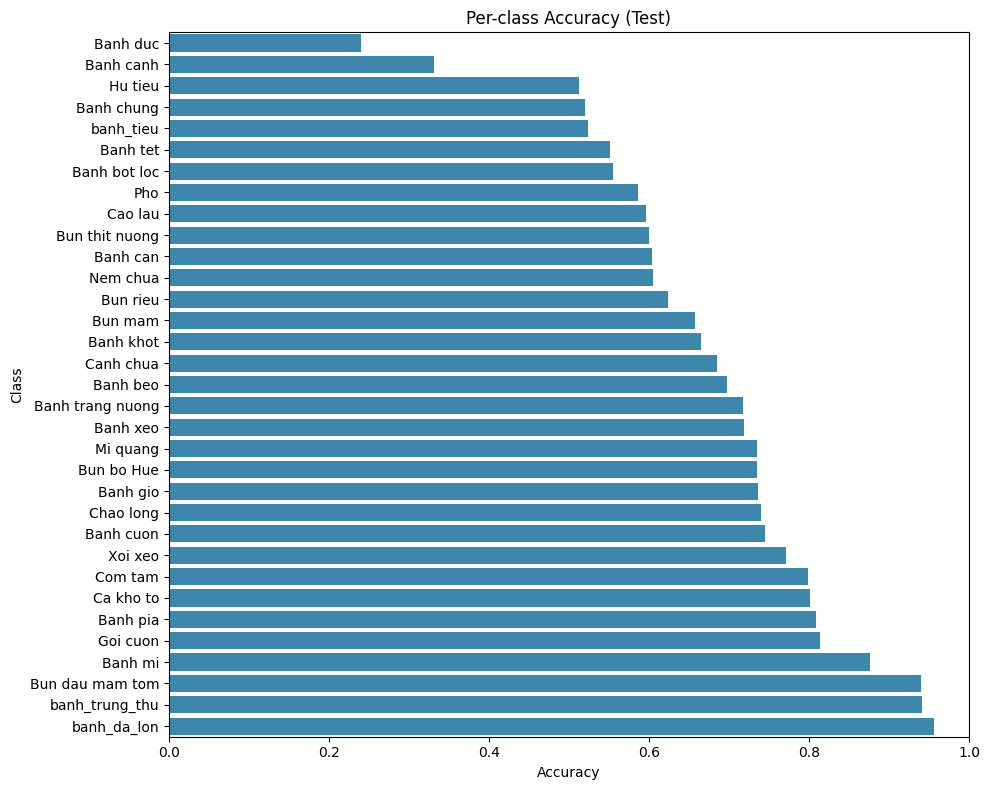

In [49]:
# %% 4. Per-class accuracy barplot
per_class_acc = (cm.diagonal() / cm.sum(axis=1)).astype(float)  # NaN nếu lớp không có mẫu
per_class_acc = np.nan_to_num(per_class_acc, nan=0.0)

order_idx = np.argsort(per_class_acc)   # sắp xếp từ thấp đến cao
plt.figure(figsize=(10, 8))
sns.barplot(x=per_class_acc[order_idx], y=np.array(CLASS_NAMES)[order_idx], orient='h', color='#2b8cbe')
plt.xlim(0, 1)
plt.xlabel("Accuracy")
plt.ylabel("Class")
plt.title("Per-class Accuracy (Test)")
plt.tight_layout()
plt.show()

In [50]:
# %% 5. Top-5 Accuracy
top5_idx = np.argpartition(-y_prob, kth=5, axis=1)[:, :5]
top5_hit = np.array([t in top5 for t, top5 in zip(y_true, top5_idx)])
top5_acc = top5_hit.mean()
print(f"✅ Top-5 Accuracy: {top5_acc*100:.2f}%")


✅ Top-5 Accuracy: 91.69%


In [51]:
# “Most confused pairs” – cặp lớp hay bị lẫn nhất
# %% 6. Top confused pairs
import itertools

cm_offdiag = cm.copy().astype(float)
np.fill_diagonal(cm_offdiag, 0)
pairs = []
for i, j in itertools.permutations(range(NUM_CLASSES), 2):
    if cm.sum(axis=1)[i] > 0:
        rate = cm[i, j] / cm.sum(axis=1)[i]
        pairs.append(((CLASS_NAMES[i], CLASS_NAMES[j]), rate))

pairs = sorted(pairs, key=lambda x: x[1], reverse=True)[:10]
print("Top-10 confused pairs (True → Pred) (rate):")
for (ti, pj), r in pairs:
    print(f"  {ti:20s} → {pj:20s} : {r:.3f}")


Top-10 confused pairs (True → Pred) (rate):
  Banh duc             → Banh cuon            : 0.233
  Banh chung           → Banh tet             : 0.176
  Banh tet             → Banh chung           : 0.152
  Bun rieu             → Bun bo Hue           : 0.143
  Pho                  → Bun bo Hue           : 0.130
  Bun thit nuong       → Com tam              : 0.127
  Banh canh            → Hu tieu              : 0.124
  Cao lau              → Mi quang             : 0.121
  Banh can             → Banh khot            : 0.107
  Bun bo Hue           → Bun rieu             : 0.101


In [52]:
# %% 6B. Hiển thị ảnh minh họa cặp bị nhầm
import random
from PIL import Image

# Lấy top 6 cặp dễ nhầm nhất
top_pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:6]

ncols = 3
plt.figure(figsize=(15, 10))

for idx, (true_cls, pred_cls, rate) in enumerate(top_pairs, 1):
    # Lấy ảnh mẫu ngẫu nhiên từ lớp thật
    true_dir = os.path.join(TEST_DIR, true_cls)
    pred_dir = os.path.join(TEST_DIR, pred_cls)
    
    # kiểm tra có ảnh
    true_imgs = [f for f in os.listdir(true_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]
    pred_imgs = [f for f in os.listdir(pred_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]
    
    if not true_imgs or not pred_imgs:
        continue  # bỏ qua nếu thiếu ảnh

    img_true = Image.open(os.path.join(true_dir, random.choice(true_imgs))).convert('RGB')
    img_pred = Image.open(os.path.join(pred_dir, random.choice(pred_imgs))).convert('RGB')

    # ảnh 1: thật
    plt.subplot(6, ncols, (idx - 1) * ncols + 1)
    plt.imshow(img_true)
    plt.axis("off")
    plt.title(f"Thật: {true_cls}", fontsize=10, color='green')

    # ảnh 2: dự đoán nhầm
    plt.subplot(6, ncols, (idx - 1) * ncols + 2)
    plt.imshow(img_pred)
    plt.axis("off")
    plt.title(f"Nhầm thành: {pred_cls}", fontsize=10, color='red')

    # ô 3: thông tin
    plt.subplot(6, ncols, (idx - 1) * ncols + 3)
    plt.axis("off")
    plt.text(0, 0.6, f"Tỉ lệ nhầm: {rate*100:.2f}%", fontsize=11, weight='bold')
    plt.text(0, 0.3, f"→ {true_cls} → {pred_cls}", fontsize=10)

plt.suptitle("Ảnh minh họa các cặp bị nhầm nhiều nhất", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


IndexError: tuple index out of range